In [425]:
%load_ext autoreload
%autoreload 2

from MPC.utils import findIC
from para_stl import paraset
import os
import pickle
from stlpy.benchmark.reach_avoid import ReachAvoid
from stlpy.benchmark.random_multitarget import RandomMultitarget
import numpy as np
from stl_planner import STL_planner
import cvxpy as cp
from solvers.OMISTL import OMISTL
import plot
from train_stl import train_horizon_stl
from sampling import sampling_stl
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [623]:
N=15
x0 = [1,0.5,0,0]
# x0=[0.5,2,0,0]
vmax = 0.5
prob_params= {}
prob_params['x0'] = x0
Q = 1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 1e-1*np.eye(2)

posmin = np.array([0.0, 0.0, -1.0, -1.0])
posmax =np.array([3.5,2.5, 1.0, 1.0])
umax = np.array([0.2, 0.2])

goal_bounds = (2.90, 3.25, 2.00, 2.25)     # (xmin, xmax, ymin, ymax)
obstacle_bounds = (1.25, 1.75, 0.20, 1.00)

rec=[]
rec.append(list(goal_bounds))
rec.append(list(obstacle_bounds))

scenario = ReachAvoid(goal_bounds, obstacle_bounds, N-1)
spec = scenario.GetSpecification()
spec.simplify()
spec_name= 'ReachAvoid'

# paraset(N=N,n_obs=5, Q=Q,R=R, xmin= posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name, vector=vector_mat)
paraset(N=N,n_obs=5, Q=Q,R=R, xmin= posmin,obstacles=rec, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name)

In [624]:
# for i in range(len(spec.subformula_list)):
#     print(spec.subformula_list[0].combination_type)

len(spec.subformula_list[0].subformula_list)

15

In [629]:
#load train/test data
dataset_name = '{}_horizon_{}'.format(spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

prob = STL_planner(config=config_fn , spec=spec)
prob.init_stl_problem(True)
prob_success, cost, solve_time,integer, vector, optvals =prob.solve_stl(prob_params,solver=cp.GUROBI,verbose=True)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 23 08:50:48 PM: Your problem has 223 variables, 202 constraints, and 4 parameters.
(CVXPY) Oct 23 08:50:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 23 08:50:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 23 08:50:48 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 23 08:50:48 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 23 08:50:48 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 23 08:50:48 PM: Applying reduction Qp2Symb

In [451]:
solve_time

0.10936927795410156

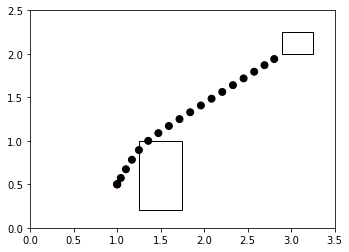

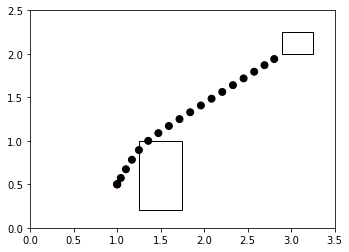

In [452]:
plot.reach_avoid_plot(optvals,scenario,prob_params)

In [427]:
inter_matrix = []
for i in range(len(prob.vector)):
    # print(prob.integer[i].value)
    inter_matrix.append(prob.vector[i].value)
inter_matrix

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0.])]

In [436]:
prob.init_pred_problem(inter_matrix)

In [437]:
prob_success, cost, solve_time, optvals =prob.solve_pred(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 23 07:25:21 PM: Your problem has 137 variables, 89 constraints, and 4 parameters.
(CVXPY) Oct 23 07:25:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 23 07:25:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 23 07:25:21 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 23 07:25:21 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 23 07:25:21 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 23 07:25:21 PM: Applying reduction Qp2Symbo

In [438]:
print(prob_success)
print(solve_time)

True
0.015625


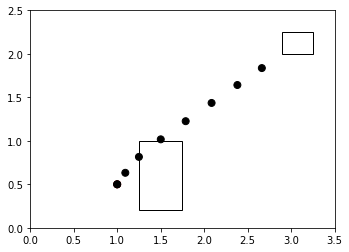

In [132]:
plot.reach_avoid_plot(optvals,scenario,prob_params)

In [625]:
N=10
# x0 = np.array([2.0,8.0,0,0])
# prob_params= {}
# prob_params['x0'] = x0
x0 = [1,0.5,0,0]
vmax = 0.5
prob_params= {}
prob_params['x0'] = x0
Q = 1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 1e-1*np.eye(2)

posmin = np.array([0.0, 0.0, -1.0, -1.0])
posmax =np.array([3.5,2.5, 1.0, 1.0])
umax = np.array([0.2, 0.2])

goal_bounds = (2.90, 3.25, 2.00, 2.25)     # (xmin, xmax, ymin, ymax)
obstacle_bounds = (1.25, 1.75, 0.20, 1.00)


rec=[]
rec.append(list(goal_bounds))
rec.append(list(obstacle_bounds))

scenario = ReachAvoid(goal_bounds, obstacle_bounds, N-1)
spec = scenario.GetSpecification()
spec.simplify()
spec_name= 'ReachAvoid'

# paraset(N=N,n_obs=5, Q=Q,R=R, xmin= posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name, vector=vector_mat)
paraset(N=N,n_obs=1, Q=Q,R=R, xmin= posmin,obstacles=rec, xmax = posmax, vmax=vmax, umax =umax, spec_name=spec_name,num_probs=20000)

In [626]:
dataset_name = '{}_horizon_{}'.format(spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config = pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

In [334]:
# sampling_stl(spec_name,spec,N)

### load train data

In [355]:
relative_path = os.getcwd()
train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
train_file = open(train_fn,'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)

In [365]:
train_data[8]

IndexError: list index out of range

### set model

In [337]:
system = spec_name
prob_features = ['x0']
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
stl_obj.setup_network()
stl_obj.model
print(stl_obj.n_strategies)

171


In [341]:
fn_saved = '../../models/{}_horizon_{}.pt'.format(scenario.spec_name,str(N))
prob = STL_planner(config=config_fn , spec=spec)
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
stl_obj.setup_network()
stl_obj.load_network(fn_saved)
stl_obj.model

Loading presaved classifier model from ../../models/ReachAvoid_horizon_10.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=171, bias=True)
  )
)

In [44]:
# train_horizon_stl(10,spec,spec_name)

Number of strategies for horizon 10: 171
Done with epoch 0 in 1.2658069133758545s
Done with epoch 1 in 1.2187492847442627s
Done with epoch 2 in 1.1877036094665527s
loss:   1.3221678733825684,   acc:  0.65625
Done with epoch 3 in 1.3750028610229492s
Done with epoch 4 in 1.7562012672424316s
Done with epoch 5 in 1.4219715595245361s
Done with epoch 6 in 1.734541654586792s
loss:   1.0924535989761353,   acc:  0.625
Done with epoch 7 in 1.5014173984527588s
Done with epoch 8 in 1.265625238418579s
Done with epoch 9 in 1.2188665866851807s
loss:   0.5727818012237549,   acc:  0.8125
Done with epoch 10 in 1.2031314373016357s
Done with epoch 11 in 1.0470912456512451s
Done with epoch 12 in 1.2970070838928223s
Done with epoch 13 in 1.312603235244751s
loss:   0.5974372625350952,   acc:  0.8125
Done with epoch 14 in 1.296966791152954s
Done with epoch 15 in 1.3212904930114746s
Done with epoch 16 in 1.2813875675201416s
loss:   0.6003618240356445,   acc:  0.78125
Done with epoch 17 in 1.2188966274261475s
D

In [354]:
x0 = [1,0.5,0,0]
p_dict= {}
p_dict['x0'] = x0
prob_success, cost, solve_time, solution, optvals_ML = stl_obj.Predict(p_dict,solver=cp.GUROBI,max_evals=16,verbose=False)
solve_time

prediction is success:True


0.0

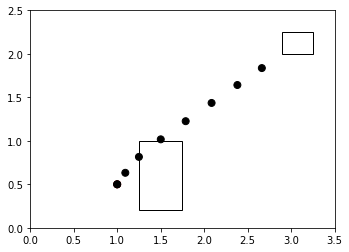

In [352]:
plot.reach_avoid_plot(optvals_ML,scenario,p_dict)

## Multi target example

In [653]:
N=30
x0 = np.array([4.0,8.0,0,0])
# x0 = np.array([2,0.5,0,0])
prob_params= {}
prob_params['x0'] = x0

vmax=1

num_obstacles = 1
num_groups = 3
targets_per_group = 2
posmin = np.array([0., 0., -1., -1.])
posmax = np.array([10., 10., 1., 1.])
max_box_size = 1.2
min_box_size = 1
box_buffer = 0.025
border_size = 0.05


scenario = RandomMultitarget(
        num_obstacles, num_groups, targets_per_group, N-1,posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size, seed=17)
spec = scenario.GetSpecification()
spec.simplify()
spec_name = scenario.spec_name
obstacles = scenario.obstacles
targets = scenario.targets

umax = np.array([0.5, 0.5])


Q = 0.001*1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 0.001*1e-1*np.eye(2)

paraset(N=N,n_obs=num_obstacles, Q=Q,R=R, xmin=posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name= spec_name, obstacles= obstacles, targets=targets)

In [654]:
dataset_name = '{}_horizon_{}'.format(scenario.spec_name,N)

relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config=pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

In [655]:
prob = STL_planner(config=config_fn , spec=spec)
prob.init_stl_problem()

In [656]:
prob_success, cost, solve_time,integer, vector, optvals =prob.solve_stl(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 23 11:30:16 PM: Your problem has 1556 variables, 2388 constraints, and 4 parameters.
(CVXPY) Oct 23 11:30:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 23 11:30:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 23 11:30:16 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 23 11:30:16 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 23 11:30:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 23 11:30:16 PM: Applying reduction Qp2Sy

In [657]:
print(prob_success)
print(solve_time)

True
20.224365234375


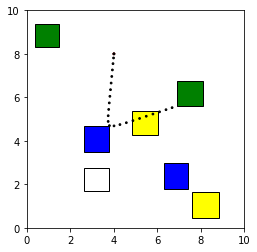

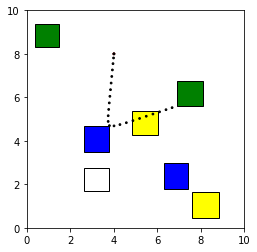

In [555]:
plot.multi_targets_plot(optvals,scenario,prob_params)

In [556]:
prob.init_pred_problem(vector)
prob_success, cost, solve_time,optvals =prob.solve_pred(prob_params,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 23 07:52:22 PM: Your problem has 342 variables, 227 constraints, and 4 parameters.
(CVXPY) Oct 23 07:52:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 23 07:52:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 23 07:52:22 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 23 07:52:22 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 23 07:52:22 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 23 07:52:22 PM: Applying reduction Qp2Symb

In [557]:
print(prob_success)
print(solve_time)

True
0.03125190734863281


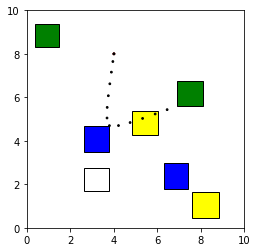

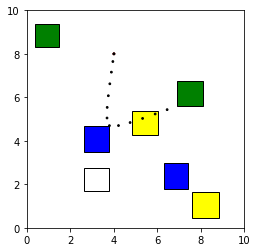

In [536]:
plot.multi_targets_plot(optvals,scenario,prob_params)

## Sampling

In [311]:
N=25
# x0 = np.array([2.0,8.0,0,0])
# prob_params= {}
# prob_params['x0'] = x0

vmax=1
num_obstacles = 1
num_groups = 3
targets_per_group = 2
posmin = np.array([0., 0., -1., -1.])
posmax = np.array([10., 10., 1., 1.])
max_box_size = 1.2
min_box_size = 1
box_buffer = 0.025
border_size = 0.05

scenario = RandomMultitarget(
        num_obstacles, num_groups, targets_per_group, N-1,posmin, posmax, \
                    border_size, box_buffer, min_box_size, max_box_size, seed=17)
spec = scenario.GetSpecification()
spec_name = scenario.spec_name
spec.simplify()

obstacles = scenario.obstacles
targets = scenario.targets

umax = np.array([0.5, 0.5])


Q = 0.001*1e-1*np.diag([0,0,1,1])   # just penalize high velocities
R = 0.001*1e-1*np.eye(2)

paraset(N=N,n_obs=num_obstacles, Q=Q,R=R, xmin=posmin, xmax = posmax, vmax=vmax, umax =umax, spec_name= spec_name, obstacles= obstacles, targets=targets, num_probs=10000)

In [312]:
dataset_name = '{}_horizon_{}'.format(spec_name,N)

#加载设置文件地址，config = [dataset_name, prob_params, sampled_params]#
relative_path = os.getcwd()
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

config_file = open(config_fn,'rb')
config = pickle.load(config_file)

dataset_name =  config[0]
config_file.close()#读取设置#

In [293]:
sampling_stl(spec_name,spec,N)

  0%|          | 1/10000 [00:04<13:14:00,  4.76s/it]


KeyboardInterrupt: 

In [370]:
relative_path = os.getcwd()
train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
train_file = open(train_fn,'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
system = scenario.spec_name
prob_features = ['x0']
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
print(stl_obj.n_strategies)

3271


In [28]:
# train_horizon_stl(25,spec)

Number of strategies for horizon 25: 3271
Done with epoch 0 in 0.7187447547912598s
Done with epoch 1 in 0.640627384185791s
Done with epoch 2 in 0.6094915866851807s
Done with epoch 3 in 0.6093406677246094s
Done with epoch 4 in 0.6250641345977783s
Done with epoch 5 in 0.6094105243682861s
Done with epoch 6 in 0.562462568283081s
loss:   4.344592094421387,   acc:  0.15625
Done with epoch 7 in 0.5470478534698486s
Done with epoch 8 in 0.5625121593475342s
Done with epoch 9 in 0.5468649864196777s
Done with epoch 10 in 0.546907901763916s
Done with epoch 11 in 0.5314681529998779s
Done with epoch 12 in 0.5937573909759521s
Done with epoch 13 in 0.5937480926513672s
loss:   3.2883923053741455,   acc:  0.15625
Done with epoch 14 in 0.5782649517059326s
Done with epoch 15 in 0.5312552452087402s
Done with epoch 16 in 0.5469188690185547s
Done with epoch 17 in 0.5312502384185791s
Done with epoch 18 in 0.5470218658447266s
Done with epoch 19 in 0.5312497615814209s
Done with epoch 20 in 0.5313856601715088s
lo

In [371]:
fn_saved = '../../models/{}_horizon_{}.pt'.format(scenario.spec_name,str(N))
prob = STL_planner(config=config_fn , spec=spec)
stl_obj = OMISTL(system, prob, prob_features)
stl_obj.construct_stl_strategies(train_data,4)
stl_obj.setup_network()
stl_obj.load_network(fn_saved)
stl_obj.model

Loading presaved classifier model from ../../models/RandomMultitarget_horizon_25.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=3271, bias=True)
  )
)

In [405]:
prob.init_stl_problem()
p_dict = {}

p_dict['x0'] = [9,8,0,0]
# p_dict['x0'] = [3,9,0,0]
# p_dict['x0'] = [9,2.2,0,0]
# p_dict['x0'] = [2,1.5,0,0]

prob_success, cost, solve_time, sos1 ,vector, optvals_ori =prob.solve_stl(p_dict,solver=cp.GUROBI)

                                     CVXPY                                     
                                    v1.1.20                                    
(CVXPY) Oct 23 03:14:09 PM: Your problem has 1301 variables, 1998 constraints, and 4 parameters.
(CVXPY) Oct 23 03:14:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 23 03:14:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 23 03:14:09 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Oct 23 03:14:09 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Oct 23 03:14:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 23 03:14:09 PM: Applying reduction Qp2Sy

In [406]:
print('Original problem has 1998 constraints，1301 variables which contains 93 integer variables')
print('Solving original problem with STL tree encoding spends : ' + str(solve_time)+ 's')

Original problem has 1998 constraints，1301 variables which contains 93 integer variables
Solving original problem with STL tree encoding spends : 1.9795417785644531s


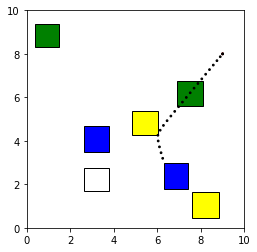

In [407]:
figure = plot.multi_targets_plot(optvals_ori,scenario,p_dict)
my_path = 'G:\destop\project\SYCAMORE_report_template/figure'
figure.savefig(my_path + "/multi_targets4.png")

In [326]:
prob.init_stl_problem(True)
prob_success, cost, solve_time, sos1 ,vector, optvals_ori =prob.solve_stl(p_dict,solver=cp.GUROBI,verbose=False)

In [327]:
print('original problem has 1506 constraints，1180 variables which contains 250 integer variables')
print('solving original problem using standard STL encoding spends : ' + str(solve_time)+ 's')

original problem has 1506 constraints，1180 variables which contains 250 integer variables
solving original problem using standard STL encoding spends : 1.2344112396240234s


In [376]:
prob_success, cost, solve_time, solution, optvals_ML = stl_obj.Predict(p_dict,solver=cp.GUROBI,max_evals=16,verbose=False)

C:\Users\msi\anaconda3\envs\coco\lib\site-packages\cvxpy\problems\problem.py:1306: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


In [377]:
print('reduced problem has 342 constraints，227 variables which contains 0 integer variables')
print('solving reduced ML problem using STL tree spends : ' + str(solve_time)+ 's')

reduced problem has 342 constraints，227 variables which contains 0 integer variables
solving reduced ML problem using STL tree spends : 0.0s


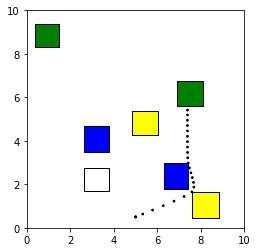

In [378]:
plot.multi_targets_plot(optvals_ML,scenario,p_dict)